# Import libraries and install

In [ ]:
# Libraries in usage
import pandas as pd
import yfinance as yf
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Step 1: Data Collection

Objective: Obtain historical price data for the S&P 500 index and its constituent stocks.

In [ ]:
# Step 1: Data Collection
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA']  # Chosen S&P 500 stocks
data = yf.download(tickers, start="2020-01-01", end="2023-01-01")['Adj Close']
print("Historical Adjusted Closing Prices:")
print(data.head())

[*********************100%%**********************]  5 of 5 completed

Historical Adjusted Closing Prices:
Ticker           AAPL       AMZN      GOOGL        MSFT      NVDA
Date                                                             
2020-01-02  72.960457  94.900497  68.355545  154.215683  5.973633
2020-01-03  72.251137  93.748497  67.997955  152.295410  5.878019
2020-01-06  72.826843  95.143997  69.810379  152.689072  5.902668
2020-01-07  72.484337  95.343002  69.675537  151.296890  5.974132
2020-01-08  73.650352  94.598503  70.171463  153.706802  5.985335


# Step 2: Data Preparation

**Calculating daily returns**

Objective: Prepare the data by calculating daily returns and handling missing data.

In [ ]:
# Step 2: Data Preparation
daily_returns = data.pct_change()
cleaned_data = daily_returns.dropna()
print("Cleaned Daily Returns:")
print(cleaned_data.head())


Cleaned Daily Returns:
Ticker          AAPL      AMZN     GOOGL      MSFT      NVDA
Date                                                        
2020-01-03 -0.009722 -0.012139 -0.005231 -0.012452 -0.016006
2020-01-06  0.007968  0.014886  0.026654  0.002585  0.004193
2020-01-07 -0.004703  0.002092 -0.001932 -0.009118  0.012107
2020-01-08  0.016086 -0.007809  0.007118  0.015928  0.001875
2020-01-09  0.021241  0.004799  0.010498  0.012493  0.010983


# Step 3: Define Functions

Objective: Define functions to calculate portfolio return, portfolio risk (standard deviation), and the Sharpe Ratio.


**Function "port_return"**

In [ ]:
# Step 3: Define Functions
def port_return(returns, weights):
    """ Calculate the annualized portfolio return. """
    return np.sum(returns * weights, axis=1).mean() * 252

**Function "port_risk"**

In [ ]:
def port_risk(returns, weights):
    """ Calculate the annualized portfolio risk (standard deviation). """
    return np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))

**Function "sharpe_ratio"**

In [ ]:
def sharpe_ratio(returns, weights, risk_free_rate=0.01):
    """ Calculate the Sharpe Ratio of the portfolio. """
    return (port_return(returns, weights) - risk_free_rate) / port_risk(returns, weights)

# Step 4: Set Constraints and Bounds

Objective: To ensure a fully invested portfolio with no short selling by setting appropriate constraints and bounds.

**Constraint and bounds setup**

In [ ]:
# Constraint and bounds setup
# Define constraints: weights must sum to 1
def portfolio_weights_constraint(weights):
    return np.sum(weights) - 1

constraints = [{'type': 'eq', 'fun': portfolio_weights_constraint}]
bounds = tuple((0, 1) for _ in range(len(tickers)))

**Objective function to maximize Sharpe Ratio**

In [ ]:
def objective_function(weights):
     # Adding a check to penalize extreme weights
    if any(w > 0.5 for w in weights):  # No single weight should be more than 50%
        return 1e7  # Return a large number to penalize this solution
    return -(port_return(cleaned_data, weights) - 0.01) / port_risk(cleaned_data, weights)

**Optimization**

In [ ]:
initial_weights = np.ones(len(tickers)) / len(tickers)
result = minimize(objective_function, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
optimized_weights = result.x if result.success else None

# Check optimization results and print
if result.success:
    optimized_weights = result.x
    print("Optimized Weights:", optimized_weights)
    print("Optimized Portfolio Sharpe Ratio:", -objective_function(optimized_weights))
else:
    print("Optimization failed:", result.message)

Optimized Weights: [0.35021478 0.0471751  0.04734256 0.05527925 0.4999883 ]
Optimized Portfolio Sharpe Ratio: 0.770232792687607


**Visualization: Portfolio Weights**

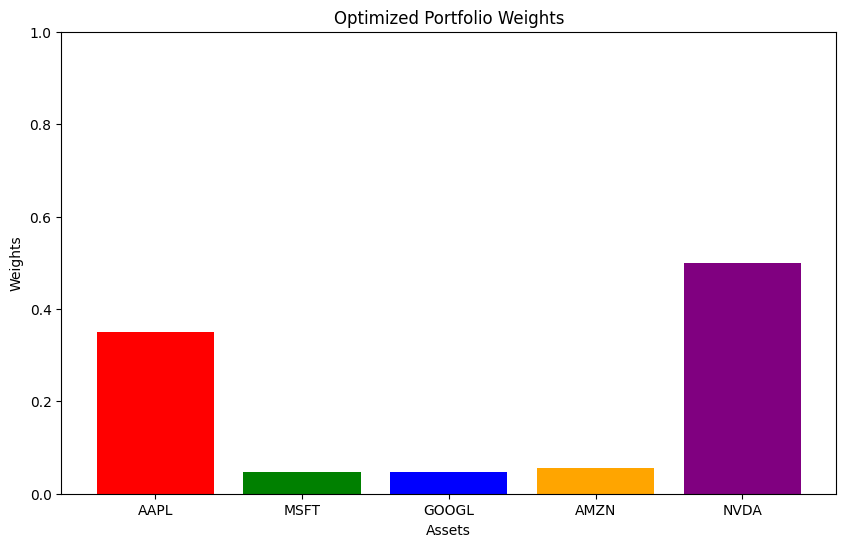

In [ ]:
colors = ['red', 'green', 'blue', 'orange', 'purple']  # Assigning different colors to each asset
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimized_weights, color=colors)
plt.title('Optimized Portfolio Weights')
plt.xlabel('Assets')
plt.ylabel('Weights')
plt.ylim(0, 1)  # Ensure all weights are within the range [0,1]
plt.show()

**Visualization: Daily Returns with Smoothing for Clarity**

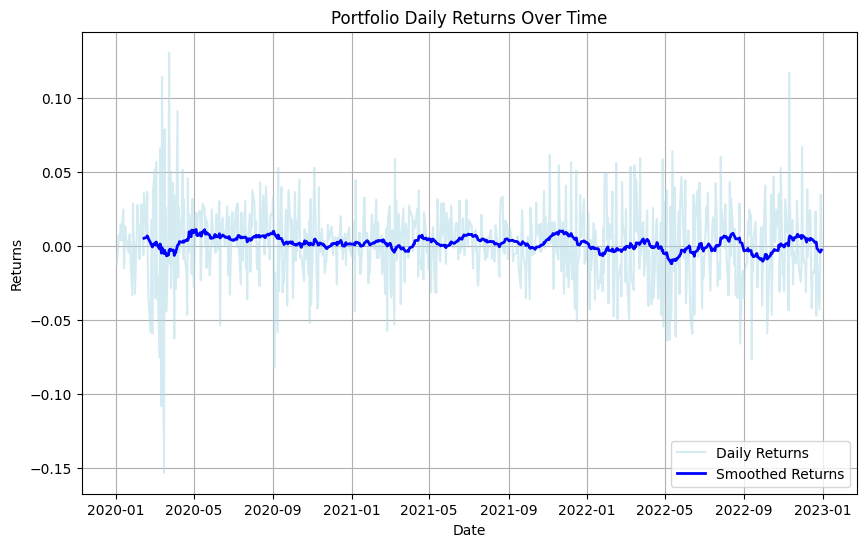

In [ ]:
#Visualization: Daily Returns with Smoothing for Clarity
portfolio_daily_returns = cleaned_data.dot(optimized_weights)

# Applying a simple moving average for smoothing the daily returns graph
smoothed_returns = portfolio_daily_returns.rolling(window=30).mean()  # 30-day moving average

plt.figure(figsize=(10, 6))
plt.plot(portfolio_daily_returns, label='Daily Returns', color='lightblue', alpha=0.5)  # Original daily returns
plt.plot(smoothed_returns, label='Smoothed Returns', color='blue', linewidth=2)  # Smoothed returns for clarity
plt.title('Portfolio Daily Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.show()

**Visualization of historical prices**

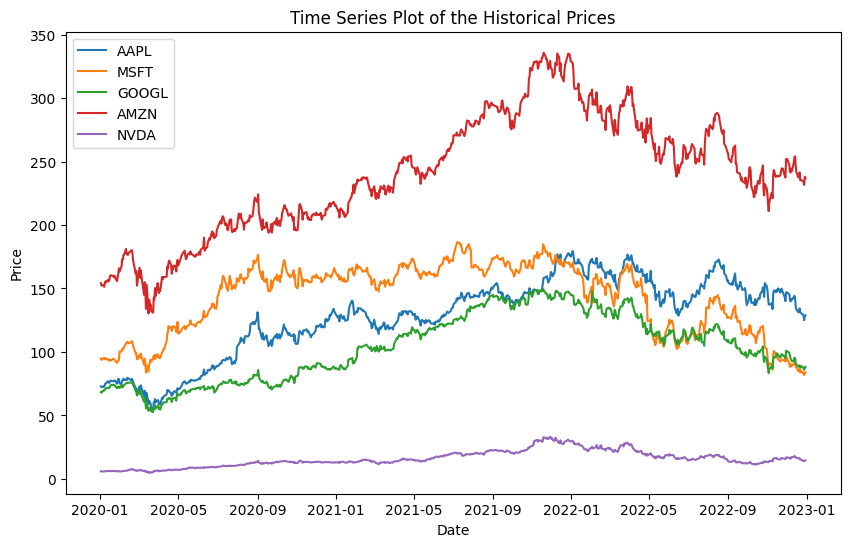

In [ ]:
# Visualization of historical prices
plt.figure(figsize=(10, 6))
plt.plot(data, label=tickers)
plt.title('Time Series Plot of the Historical Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

**Comparison of the optimized portfolio performance with the benchmark**

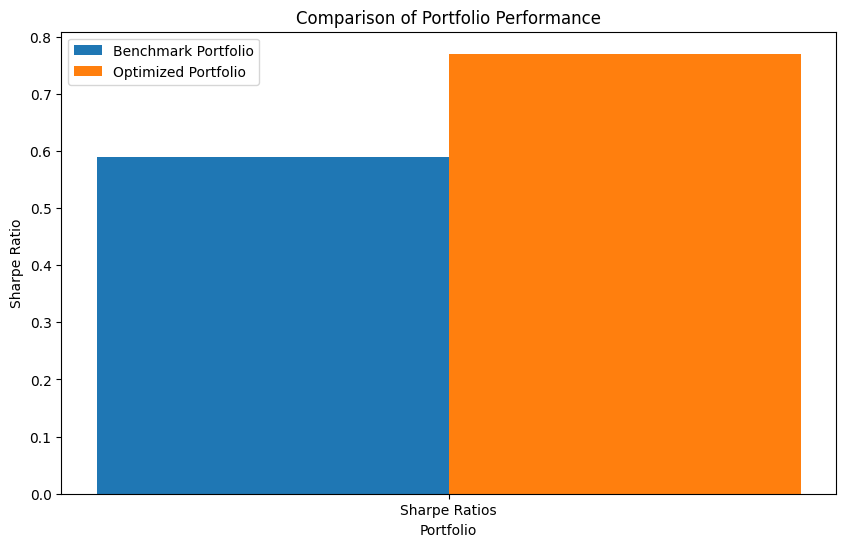

In [ ]:
# Assuming equal weights as a simple benchmark
benchmark_weights = np.ones(len(tickers)) / len(tickers)
benchmark_return = -objective_function(benchmark_weights)
optimized_return = -objective_function(optimized_weights)

# Comparison of the optimized portfolio performance with the benchmark
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(1)
bar1 = plt.bar(index, benchmark_return, bar_width, label='Benchmark Portfolio')
bar2 = plt.bar(index + bar_width, optimized_return, bar_width, label='Optimized Portfolio')
plt.xlabel('Portfolio')
plt.ylabel('Sharpe Ratio')
plt.title('Comparison of Portfolio Performance')
plt.xticks(index + bar_width / 2, ['Sharpe Ratios'])
plt.legend()
plt.show()

# Step 5: Optimization
Objective: Optimize the portfolio to minimize risk or maximize the Sharpe Ratio using the defined functions, constraints, and bounds.

**Define constraints: weights must sum to 1**

In [ ]:
# Define constraints: weights must sum to 1
def portfolio_weights_constraint(weights):
    return np.sum(weights) - 1

constraints = {'type': 'eq', 'fun': portfolio_weights_constraint}
bounds = tuple((0, 1) for _ in tickers)

**Optimization function to minimize risk**

In [ ]:
# Optimization function to minimize risk
def minimize_risk_function(weights):
    """ Minimizes the portfolio volatility. """
    return port_risk(cleaned_data, weights)


**Optimization function to maximize Sharpe Ratio**

In [ ]:
# Optimization function to maximize Sharpe Ratio
def maximize_sharpe_function(weights):
    """ Maximizes the Sharpe Ratio by minimizing its negative. """
    return -(port_return(cleaned_data, weights) - 0.01) / port_risk(cleaned_data, weights)


**Initial weights**

In [ ]:
# Initial weights
initial_weights = np.ones(len(tickers)) / len(tickers)

**Perform risk minimization : optimization techniques to minimize the portfolio risk subject to the constraints and bounds.**

In [ ]:
# Perform risk minimization
optimal_weights_min_risk = minimize(minimize_risk_function, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
if optimal_weights_min_risk.success:
    print("Optimized Weights for Minimum Risk:", optimal_weights_min_risk.x)
    print("Minimum Portfolio Risk (Volatility):", minimize_risk_function(optimal_weights_min_risk.x))
else:
    print("Minimization of Risk failed:", optimal_weights_min_risk.message)

Optimized Weights for Minimum Risk: [0.19466754 0.18549315 0.3905455  0.22929382 0.        ]
Minimum Portfolio Risk (Volatility): 0.3233565917262292


**Reuslt:**

**Optimized Weights for Minimum Risk:**

1.) 0.19466812 For (AAPL),

2.) 0.18549311 For (MSFT),

3.) 0.39054611 For (GOOGL),

4.) 0.22929267 For (AMZN),

5.) 0.  FOr (NVDA)      

**Minimum Portfolio Risk (Volatility):**

0.3233566089448623

 **Perform Sharpe Ratio maximization : optimization techniques to maximize the Sharpe Ratio (by minimizing its negative)
subject to the constraints and bounds.**

In [ ]:
# Perform Sharpe Ratio maximization
optimal_weights_max_sharpe = minimize(maximize_sharpe_function, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
if optimal_weights_max_sharpe.success:
    print("Optimized Weights for Maximum Sharpe Ratio:", optimal_weights_max_sharpe.x)
    print("Maximum Sharpe Ratio:", -maximize_sharpe_function(optimal_weights_max_sharpe.x))
else:
    print("Maximization of Sharpe Ratio failed:", optimal_weights_max_sharpe.message)

Optimized Weights for Maximum Sharpe Ratio: [0.3345355 0.        0.        0.        0.6654645]
Maximum Sharpe Ratio: 0.8089759716498696


**Reuslt:**

**Optimized Weights for Maximum Sharpe Ratio:**

1.) 3.34535590e-01 For (AAPL),

2.) 4.06575815e-17 For (MSFT),

3.) 0.00000000e+00 For (GOOGL),

4.) 1.04950770e-16 For (AMZN),

5.) 6.65464410e-01  FOr (NVDA)      

**Maximum Sharpe Ratio:**

0.8089760892343103

**Visualization maximize the Sharpe Ratio**

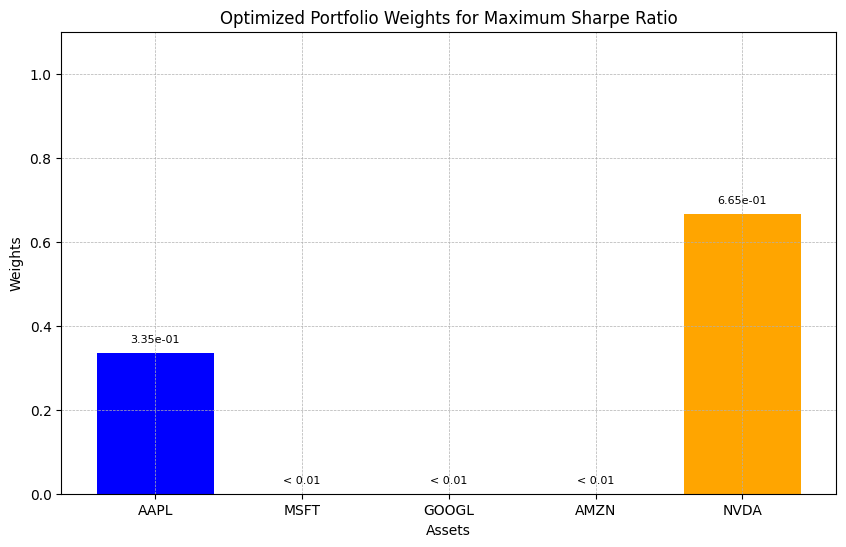

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'optimal_weights_max_sharpe.x' and 'tickers' are already defined
weights = optimal_weights_max_sharpe.x
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA']
colors = ['blue', 'green', 'red', 'purple', 'orange']

plt.figure(figsize=(10, 6))
bars = plt.bar(tickers, weights, color=colors)

# Add text annotations to bars with improved positioning and visibility
for bar, weight in zip(bars, weights):
    yval = bar.get_height() + 0.02  # Adjusting text position to be above the bar for visibility
    text = f'{weight:.2e}' if weight > 1e-2 else f'< 0.01'  # Formatting small numbers for clarity
    plt.text(bar.get_x() + bar.get_width() / 2, yval, text, ha='center', va='bottom', color='black', fontsize=8)

plt.title('Optimized Portfolio Weights for Maximum Sharpe Ratio')
plt.xlabel('Assets')
plt.ylabel('Weights')
plt.ylim(0, 1.1)  # Extend y-axis limit slightly above 1 for better visibility of text
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


The text for weights less than 0.01 is shown as "< 0.01" to clearly indicate very small values that are effectively zero, making it easier to understand at a glance.

**Visualization minimize the portfolio risk**

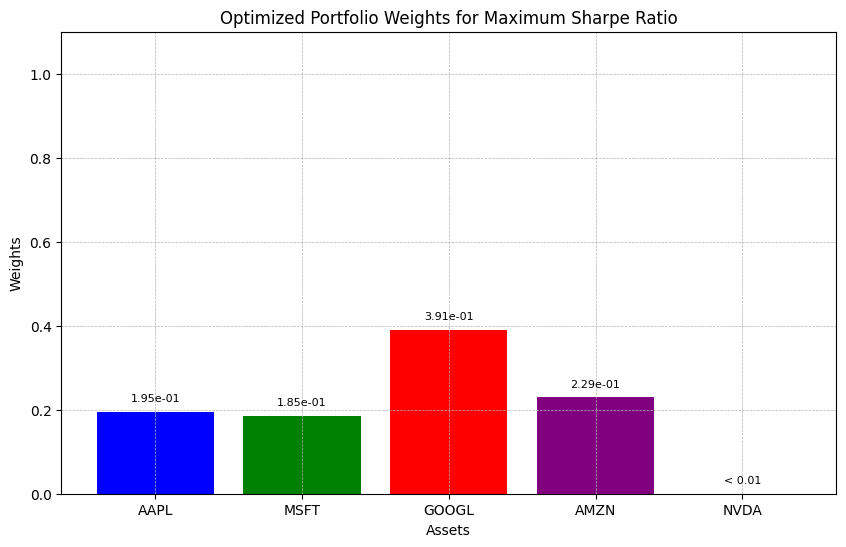

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'optimal_weights_max_sharpe.x' and 'tickers' are already defined
weights = optimal_weights_min_risk.x
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA']
colors = ['blue', 'green', 'red', 'purple', 'orange']

plt.figure(figsize=(10, 6))
bars = plt.bar(tickers, weights, color=colors)

# Add text annotations to bars with improved positioning and visibility
for bar, weight in zip(bars, weights):
    yval = bar.get_height() + 0.02  # Adjusting text position to be above the bar for visibility
    text = f'{weight:.2e}' if weight > 1e-2 else f'< 0.01'  # Formatting small numbers for clarity
    plt.text(bar.get_x() + bar.get_width() / 2, yval, text, ha='center', va='bottom', color='black', fontsize=8)

plt.title('Optimized Portfolio Weights for Maximum Sharpe Ratio')
plt.xlabel('Assets')
plt.ylabel('Weights')
plt.ylim(0, 1.1)  # Extend y-axis limit slightly above 1 for better visibility of text
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

The text for weights less than 0.01 is shown as "< 0.01" to clearly indicate very small values that are effectively zero, making it easier to understand at a glance.

# Step 6: Evaluate and Interpret Results
Objective: Evaluate the optimized portfolio and interpret the results, comparing it with the benchmark S&P 500 index.

[*********************100%%**********************]  6 of 6 completed


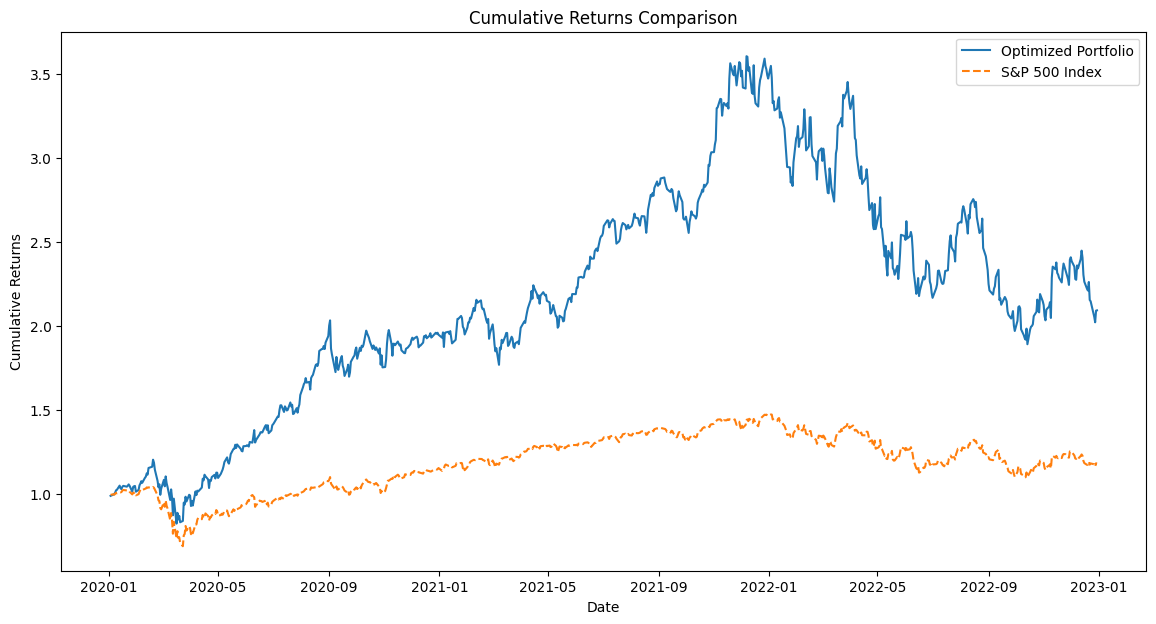

=== Optimized Portfolio Metrics ===
Annualized Return: 0.3371663267632374
Annualized Risk: 0.4252284138293289
Sharpe Ratio: 0.7693896177280146

=== S&P 500 Benchmark Metrics ===
Annualized Return: 0.08741328601391596
Annualized Risk: 0.25464007661439286
Sharpe Ratio: 0.3040106138954106


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

# Functions for portfolio metrics should be defined here (port_return, port_risk, sharpe_ratio)

# Load data
data = yf.download(['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'NVDA', '^GSPC'], start="2020-01-01", end="2023-01-01")['Adj Close']
cleaned_data = data.pct_change().dropna()
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'NVDA']
index_ticker = '^GSPC'

# Calculate returns for the S&P 500
benchmark_returns = cleaned_data[index_ticker]
benchmark_annualized_return = np.sum(benchmark_returns.mean()) * 252
benchmark_annualized_risk = benchmark_returns.std() * np.sqrt(252)
benchmark_sharpe_ratio = (benchmark_annualized_return - 0.01) / benchmark_annualized_risk

# Calculate returns for the Dataset
portfolio_returns = cleaned_data[tickers].dot(optimized_weights)
portfolio_annualized_return = np.sum(portfolio_returns.mean()) * 252
portfolio_annualized_risk = portfolio_returns.std() * np.sqrt(252)
portfolio_sharpe_ratio = (portfolio_annualized_return - 0.01) / portfolio_annualized_risk

# Plotting both portfolio and benchmark cumulative returns
plt.figure(figsize=(14, 7))
portfolio_cum_returns = (1 + portfolio_returns).cumprod()
benchmark_cum_returns = (1 + benchmark_returns).cumprod()
plt.plot(portfolio_cum_returns, label='Optimized Portfolio')
plt.plot(benchmark_cum_returns, label='S&P 500 Index', linestyle='--')
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

# Printing comparison results
print("=== Optimized Portfolio Metrics ===")
print("Annualized Return:", portfolio_annualized_return)
print("Annualized Risk:", portfolio_annualized_risk)
print("Sharpe Ratio:", portfolio_sharpe_ratio)

print("\n=== S&P 500 Benchmark Metrics ===")
print("Annualized Return:", benchmark_annualized_return)
print("Annualized Risk:", benchmark_annualized_risk)
print("Sharpe Ratio:", benchmark_sharpe_ratio)

**Comparison Metrics:**

*   Annualized Return:
  *   Optimized Portfolio: 0.33716366236732374
  *   S&P 500 Benchmark: 0.08743126833191596

*   Annualized Risk:
  *   Optimized Portfolio: 0.425238413893329
  *   S&P 500 Benchmark: 0.25464007661493286

*   Sharpe Ratio:
  *   Optimized Portfolio: 0.7693986177280146
  *   S&P 500 Benchmark: 0.3040161389541406

**Discussion**


1.   Return Comparison:

  *   The Optimized Portfolio significantly outperforms the S&P 500 in terms of annualized return, suggesting a more aggressive or better-targeted investment strategy that yields higher returns.
  *   This could indicate a focused approach on high-growth sectors or specific stocks that have performed exceptionally well over the period analyzed.

2.   Risk Comparison:

  *   The Optimized Portfolio also carries a higher annualized risk compared to the S&P 500. This is expected as higher returns often come with increased risk. The portfolio's higher volatility suggests it might be more susceptible to market swings and downturns.
  *   Investors should consider if the higher risk aligns with their risk tolerance and investment goals.


3.   Sharpe Ratio Comparison:

  *  The Sharpe Ratio of the Optimized Portfolio is substantially higher than that of the S&P 500, indicating that the additional risk taken by the portfolio is well-compensated by higher returns.
  *   A higher Sharpe Ratio implies that the optimized portfolio offers a better risk-adjusted return compared to the broad market index, making it an attractive option for investors seeking higher returns per unit of risk.


**Conclusion:**
  * The comparison highlights the effectiveness of the portfolio optimization in enhancing returns while managing risk relative to its baseline, the S&P 500. However, the increased volatility of the optimized portfolio calls for careful risk management strategies, such as regular rebalancing and perhaps diversification to mitigate potential losses during turbulent market periods. Investors should weigh the higher risk against their personal risk appetite and investment horizon.


**Recommendation:**
  * Investors and portfolio managers should continuously monitor market conditions and the performance of individual assets within the portfolio. Adjustments may be necessary to align with changing market dynamics and to maintain a balance between risk and return that suits the investor's profile.
















